In [1]:
import re
import nltk
import codecs
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import preprocessing
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
STOPWORDS = set(stopwords.words('english'))

## Loading and analyzing data 

In [3]:
beer_review = pd.read_csv("train.csv")

In [4]:
beer_review

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.00,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz
1,8135,11.00,3003,395,Bearded Pat's Barleywine,American Barleywine,4.0,3.5,3.5,3.5,3.0,12oz bottle into 8oz snifter.\t\tDeep ruby red...,"{'min': 38, 'hour': 23, 'mday': 8, 'sec': 58, ...",1218238738,NaN,NaN,NaN,NaN,BeerSox
2,10529,4.70,961,365,Naughty Nellie's Ale,American Pale Ale (APA),3.5,4.0,3.5,3.5,3.5,First enjoyed at the brewpub about 2 years ago...,"{'min': 7, 'hour': 18, 'mday': 26, 'sec': 2, '...",1101492422,NaN,NaN,NaN,Male,mschofield
3,44610,4.40,429,1,Pilsner Urquell,Czech Pilsener,3.0,3.0,2.5,3.0,3.0,First thing I noticed after pouring from green...,"{'min': 7, 'hour': 1, 'mday': 20, 'sec': 5, 'y...",1308532025,1.209827e+09,"Aug 10, 1976",208508400.0,Male,molegar76
4,37062,4.40,4904,1417,Black Sheep Ale (Special),English Pale Ale,4.0,3.0,3.0,3.5,2.5,A: pours an amber with a one finger head but o...,"{'min': 51, 'hour': 6, 'mday': 12, 'sec': 48, ...",1299912708,NaN,NaN,NaN,NaN,Brewbro000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37495,35175,5.50,22450,3268,Blackberry Scottish-Style,Fruit / Vegetable Beer,4.0,3.5,3.5,3.5,3.5,12 oz brown longneck with no freshness dating....,"{'min': 56, 'hour': 23, 'mday': 10, 'sec': 1, ...",1207871761,NaN,NaN,NaN,NaN,Redrover
37496,23666,8.50,7463,1199,Founders Dirty Bastard,Scotch Ale / Wee Heavy,4.5,4.0,3.5,4.5,4.5,A - A bright red with a maroon-amber hue; mini...,"{'min': 45, 'hour': 5, 'mday': 10, 'sec': 14, ...",1263102314,NaN,NaN,NaN,NaN,jmerloni
37497,47720,4.75,1154,394,Stoudt's Fest,MÃ¤rzen / Oktoberfest,4.0,3.5,4.0,4.5,4.0,Sampled on tap at Redbones.\t\tThis marzen sty...,"{'min': 3, 'hour': 1, 'mday': 25, 'sec': 36, '...",1067043816,NaN,NaN,NaN,NaN,UncleJimbo
37498,33233,11.20,19960,1199,Founders KBS (Kentucky Breakfast Stout),American Double / Imperial Stout,4.0,4.0,4.0,5.0,5.0,Pours a black body with a brown head that very...,"{'min': 52, 'hour': 19, 'mday': 29, 'sec': 33,...",1296330753,NaN,NaN,NaN,NaN,Stockfan42


In [5]:
beer_review.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName'],
      dtype='object')

In [6]:
beer_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user/birthdayUnix  785

In [7]:
beer_review.isna().sum()

index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text             10
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29644
user/birthdayRaw     29644
user/birthdayUnix    29644
user/gender          22186
user/profileName         5
dtype: int64

In [8]:
beer_review.dropna(subset=['review/text'],inplace= True)

In [9]:
i = beer_review[(beer_review['review/overall']	== 0.0)].index

In [10]:
beer_review.drop(i ,inplace =True)

In [11]:
beer_review.isna().sum()

index                    0
beer/ABV                 0
beer/beerId              0
beer/brewerId            0
beer/name                0
beer/style               0
review/appearance        0
review/aroma             0
review/overall           0
review/palate            0
review/taste             0
review/text              0
review/timeStruct        0
review/timeUnix          0
user/ageInSeconds    29633
user/birthdayRaw     29633
user/birthdayUnix    29633
user/gender          22181
user/profileName         5
dtype: int64

In [12]:
beer_review.reset_index(inplace = True)

In [13]:
beer_review['beer/style'].value_counts()

American Double / Imperial Stout    4493
American IPA                        3048
American Double / Imperial IPA      2871
Scotch Ale / Wee Heavy              2133
Russian Imperial Stout              2030
                                    ... 
Berliner Weissbier                     6
Kristalweizen                          6
Eisbock                                5
BiÃ¨re de Garde                        4
Flanders Red Ale                       2
Name: beer/style, Length: 95, dtype: int64

In [14]:
beer_review['review/overall'].value_counts()

4.0    13867
4.5     8662
3.5     6550
3.0     3319
5.0     2667
2.5     1193
2.0      807
1.5      248
1.0      176
Name: review/overall, dtype: int64

In [15]:
beer_review['beer/brewerId'].value_counts()

1199     14970
394       2937
14879     2349
263       1809
3268      1277
         ...  
27133        1
15607        1
3207         1
3408         1
17783        1
Name: beer/brewerId, Length: 212, dtype: int64

In [16]:
def clean_text(text): 
    text = re.sub("\'", "", text) 
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

## Visulisation of Data

Text(0.5, 0, 'No. of reviews')

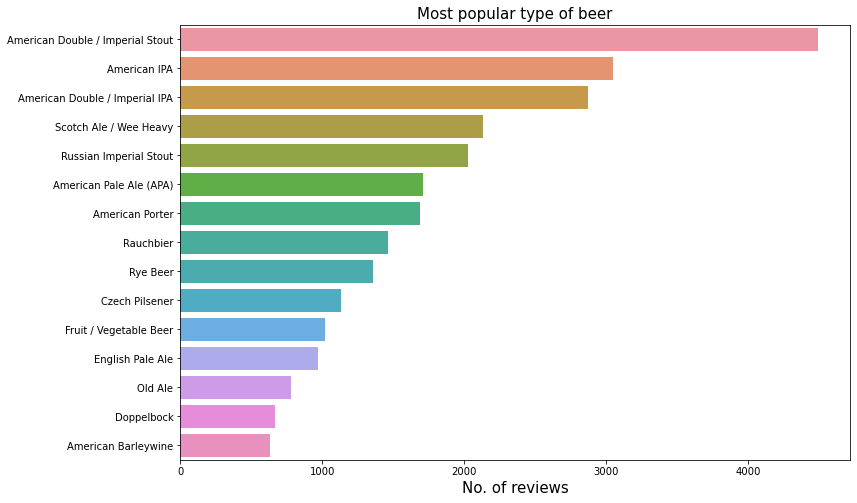

In [17]:
plt.figure(figsize=(12,8))
beer_type=beer_review['beer/style'].value_counts()[:15]
sns.barplot(x = beer_type,y = beer_type.index)
plt.title('Most popular type of beer', size = 15)
plt.xlabel('No. of reviews',size = 15)

Text(0, 0.5, 'No. of reviews')

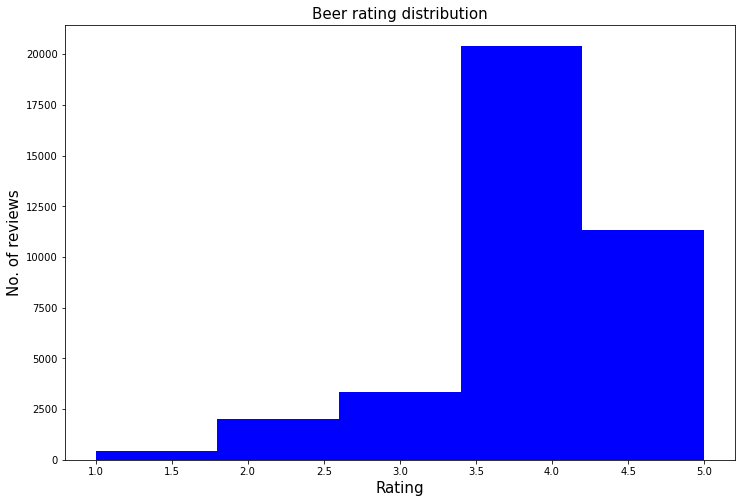

In [18]:
plt.figure(figsize=(12,8))
rating = beer_review['review/overall']
plt.hist(rating,bins=5,color="blue")
plt.title('Beer rating distribution', size = 15)
plt.xlabel('Rating',size = 15)
plt.ylabel('No. of reviews',size = 15)

Text(0.5, 1.0, 'Taste Review Vs Overall Review')

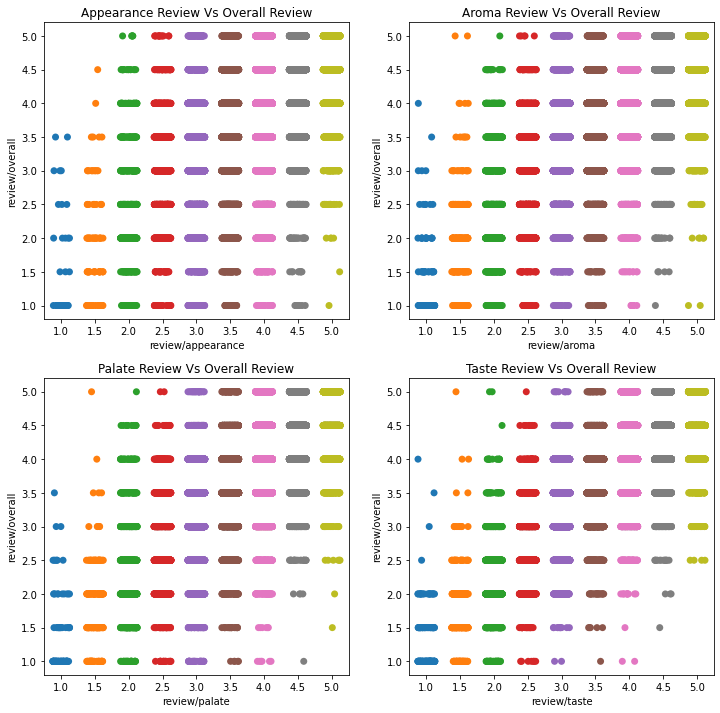

In [19]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
sns.stripplot(x = 'review/appearance' , y = 'review/overall' , data = beer_review, jitter=0.25 ,size= 7, ax=axs[0, 0])
axs[0, 0].set_title("Appearance Review Vs Overall Review")
sns.stripplot(x = 'review/aroma', y = 'review/overall' , data = beer_review, jitter=0.25, size= 7,ax=axs[0, 1])
axs[0, 1].set_title("Aroma Review Vs Overall Review")
sns.stripplot(x = 'review/palate' , y = 'review/overall' , data = beer_review,jitter=0.25,size= 7, ax=axs[1, 0])
axs[1, 0].set_title("Palate Review Vs Overall Review")
sns.stripplot(x = 'review/taste' , y = 'review/overall' , data = beer_review,jitter=0.25,size= 7, ax=axs[1, 1])
axs[1, 1].set_title("Taste Review Vs Overall Review")

<AxesSubplot:>

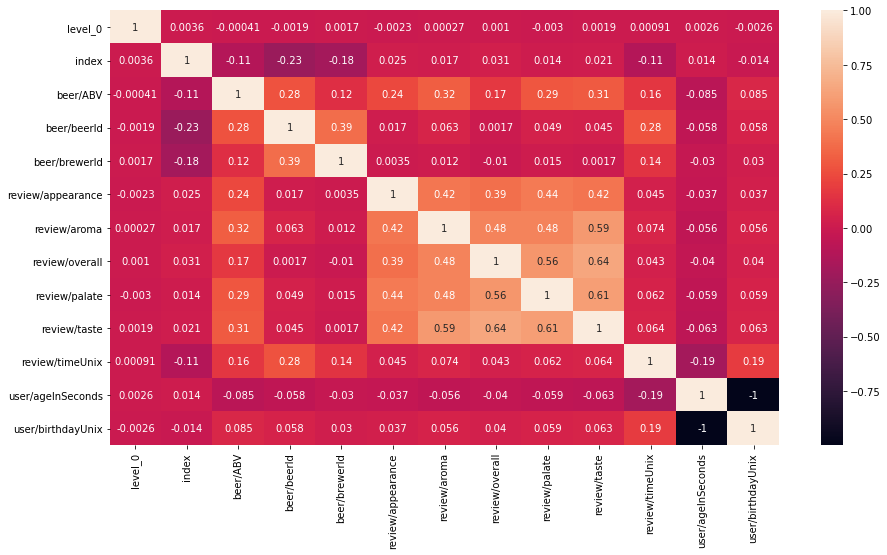

In [20]:
corr = beer_review.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

(-0.5, 999.5, 499.5, -0.5)

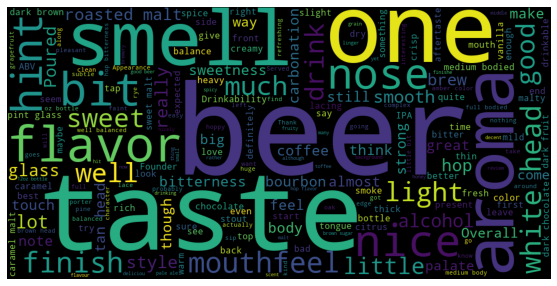

In [21]:
review_txt= (' '.join(beer_review['review/text']))
wordcloud = WordCloud(width = 1000, height = 500).generate(review_txt)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')

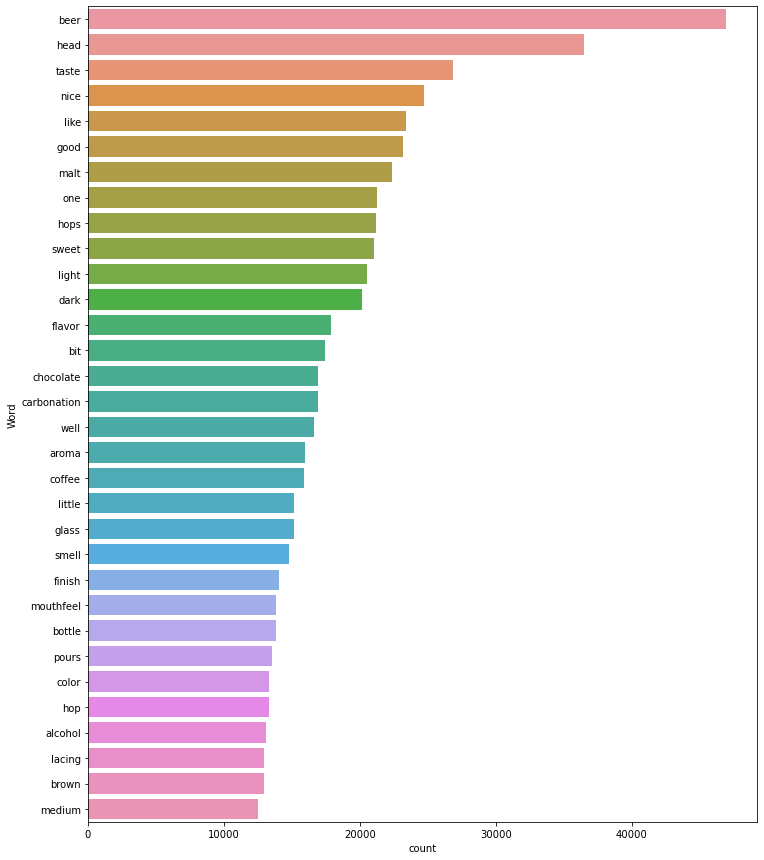

In [22]:
rev = beer_review['review/text']
rev = rev.apply(lambda x: clean_text(x)) 
all_words = ' '.join([text for text in rev]) 
all_words = all_words.split()
fdist = nltk.FreqDist(all_words) 
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
d = words_df.nlargest(columns="count", n = 32) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=d, x= "count", y = "word") 
ax.set(ylabel = 'Word') 
plt.show()

## Preprocessing of data

In [23]:
#Label Encoding to 'beer/style' to convert data into integer
lab_en = preprocessing.LabelEncoder()
beer_review['Labeled style'] = lab_en.fit_transform(beer_review['beer/style'])

In [24]:
# Using  'beer/ABV', 'beer/style', 'review/appearance', 'review/aroma','review/palate', 'review/taste'
# Ignoring User data in this case as most of userdata is null
X = beer_review[['Labeled style', 'beer/ABV','review/aroma', 'review/palate','review/taste','review/appearance']]
y = beer_review['review/overall']

In [25]:
Y = lab_en.fit_transform(y)

In [26]:
oversample = RandomOverSampler()
X, Y = oversample.fit_resample(X, Y)

In [27]:
strategy = {0:4000, 1:4000, 2:5000, 3:6000, 4:6000, 5: 8000, 6:9000 ,7:9000,8:6500}
oversample = RandomUnderSampler(sampling_strategy=strategy)
X, Y = oversample.fit_resample(X, Y)

In [28]:
 X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [29]:
normalizer = preprocessing.Normalizer()
normalized_train_X = normalizer.fit_transform(X_train)

In [30]:
normalized_test_X = normalizer.transform(X_test)

In [31]:
Yy = pd.get_dummies(Y)

In [32]:
 X_tr, X_te, y_tr, y_te = train_test_split(X, Yy, test_size=0.2, random_state=10)

In [33]:
normalizer = preprocessing.Normalizer()
normalized_tr_X = normalizer.fit_transform(X_tr)

In [34]:
normalized_te_X = normalizer.transform(X_te)

## Text Processing

In [35]:
beer_review['review/text']= beer_review['review/text'].apply(lambda x: clean_text(x))


In [36]:
X_text = beer_review['review/text']

In [37]:
def MaxLen(data):
    total_words = 0
    sequence_length = []
    idx = 0
    for row in range(len(data)):
        sentence = data[row]
        sentence_words = sentence.split()
        len_words = len(sentence_words)
        total_words = total_words + len_words
        sequence_length.append(len_words)
        if idx == 0:
            max_seq_len = len_words
        if len_words > max_seq_len:
            max_seq_len = len_words
        idx = idx + 1   
    
    return max_seq_len

In [38]:
maxlen = MaxLen(X_text)
print("The maximum length for data is", maxlen)

The maximum length for data is 583


In [39]:
token = Tokenizer()
token.fit_on_texts(X_text)
X_seq = token.texts_to_sequences(X_text)

In [40]:
pad_X = pad_sequences(X_seq,maxlen=maxlen)

In [41]:
Y_text = lab_en.fit_transform(y)

In [42]:
oversample = RandomOverSampler()
pad_X,Y_text = oversample.fit_resample(pad_X, Y_text)

In [43]:
strategy = {0:800, 1:800, 2:1000, 3:1200, 4:1200, 5: 1600, 6:1800 ,7:1800,8:1300}
oversample = RandomUnderSampler(sampling_strategy=strategy)
X_txt, Y_txt = oversample.fit_resample(pad_X, Y_text)

In [44]:
y_txt = pd.get_dummies(Y_txt)

In [45]:
xj_train, xj_test, yj_train, yj_test = train_test_split(X_txt, y_txt, test_size=0.2, random_state=0)

## Using Machine Learning Model for classification

#### XGBoost Classifier

In [46]:
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(normalized_train_X, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
pred_y = xgboost.predict(normalized_test_X)

In [48]:
print("Accuracy of XGBoost model",'%.2f' %(accuracy_score(y_test, pred_y)* 100))
print("F-1 score of XGBoost model",'%.2f' %(f1_score(y_test, pred_y, average='macro') * 100))

Accuracy of XGBoost model 72.42
F-1 score of XGBoost model 77.18


#### Random Forest Classifier

In [49]:
RForest=RandomForestClassifier(n_estimators=500)
RForest.fit(normalized_train_X,y_train)

RandomForestClassifier(n_estimators=500)

In [50]:
y_predict=RForest.predict(normalized_test_X)

In [51]:
print("Accuracy of the Random Forest model:",'%.2f' %(accuracy_score(y_test, y_predict)* 100))
print("F-1 Score of the Random Forest model:",'%.2f' %(f1_score(y_test, y_predict, average='macro') * 100))

Accuracy of the Random Forest model: 72.26
F-1 Score of the Random Forest model: 76.90


#### Support Vector Classifier

In [52]:
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(normalized_train_X,y_train)

SVC()

In [53]:
y_pred = rbf_svc.predict(normalized_test_X)

In [54]:
print("Accuracy of the SVC model",'%.2f' %(accuracy_score(y_test, y_pred)* 100))
print("F-1 Score of the SVC model",'%.2f' %(f1_score(y_test, y_pred, average='macro') * 100))

Accuracy of the SVC model 29.40
F-1 Score of the SVC model 27.50


## NLP Model along with GLoVE Embedding for Review Data

In [55]:
vocab_size = len(token.word_index)+1

In [56]:
def load_embedding(embedding_path):
    weight_vectors = {}
    word_idx = {}
    with codecs.open(embedding_path,encoding='utf-8') as f:
         for line in tqdm(f):
            value = line.split(' ')
            word = value[0]
            coef = np.array(value[1:],dtype = 'float32')
            weight_vectors[word] = coef
    return weight_vectors

In [57]:
glove = "C:/Users/Admin/Desktop/Sentiment Analysis/Glove"
weight_vector  = load_embedding(glove+'/glove_6B_300d.txt')   

400000it [00:46, 8513.42it/s]


In [58]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
    embedding_value = weight_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|██████████| 40560/40560 [00:00<00:00, 432812.81it/s]


In [59]:
def create_model(weight_matrix, max_words, EMBEDDING_DIM):
    # creation the model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(len(weight_matrix), EMBEDDING_DIM, weights=[weight_matrix], input_length=max_words, trainable=False))
    model.add(tf.keras.layers.SpatialDropout1D(0.15))
    model.add(tf.keras.layers.LSTM(75, dropout=0.25, recurrent_dropout=0.3, return_sequences=True))
    model.add(tf.keras.layers.LSTM(75, dropout=0.25, recurrent_dropout=0.3))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

In [60]:
def train_model(model,train_x, train_y) :
    earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=3, verbose=0, mode='auto')
    # Fit the model
    model.fit(train_x, train_y, epochs=15,validation_split=0.2,batch_size =10, callbacks=[earlyStopping])
    return model

In [61]:
max_words = maxlen
Embedding_dim = 300
model_text = create_model(embedding_matrix, max_words, Embedding_dim)

In [62]:
train_model(model_text,xj_train, yj_train) 

Epoch 1/15
736/736 [==============================] - 881s 1s/step - loss: 0.0992 - accuracy: 0.8889 - val_loss: 0.0988 - val_accuracy: 0.8889
Epoch 2/15
736/736 [==============================] - 920s 1s/step - loss: 0.0988 - accuracy: 0.8889 - val_loss: 0.0988 - val_accuracy: 0.8889
Epoch 3/15
736/736 [==============================] - 937s 1s/step - loss: 0.0988 - accuracy: 0.8889 - val_loss: 0.0988 - val_accuracy: 0.8889
Epoch 4/15
736/736 [==============================] - 961s 1s/step - loss: 0.0988 - accuracy: 0.8889 - val_loss: 0.0988 - val_accuracy: 0.8889


In [63]:
Yt_pred = model_text.predict(xj_test)
yt_pred = np.argmax(Yt_pred, axis=1)

In [64]:
yj_test.shape

(2300, 9)

In [65]:
y_txt= yj_test.idxmax(axis=1)

In [66]:
print("Accuracy of the Stacked LSTM model",'%.2f' %(accuracy_score(y_txt, yt_pred)* 100))
print("F-1 Score of the Stacked LSTM",'%.2f' %(f1_score(y_txt, yt_pred, average='macro') * 100))

Accuracy of the Stacked LSTM model 6.78
F-1 Score of the Stacked LSTM 1.41
